In [8]:
import cv2

from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import random
import numpy as np
from utils.dataset import ImageSet, transform
from utils.metrics import plot_metrics
from utils.utils import fix_colors

# OpenCV Scalling

In [9]:
def classic_upscale(img):
    return cv2.resize(img, [256, 256], interpolation=2) # 2 = bicubic interpolation

# Neural Network Scalling

### Dataset

In [11]:
train_dataset = ImageSet("data/scalling/train", "data/intermediate/train", transform)
valid_dataset = ImageSet("data/scalling/valid", "data/intermediate/valid", transform)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

### Model

In [ ]:
class UpscaleCNN(nn.Module):
    def __init__(self):
        super(UpscaleCNN, self).__init__()

        # Encoder: 32x32 -> feature extraction
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # 32x32 -> 32x32
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # 8x8 -> 4x4
            nn.ReLU(),
        )

        # Decoder: 4x4 -> 256x256 (upscaling)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),  # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16x16 -> 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32x32 -> 64x64
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 64x64 -> 128x128
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # 128x128 -> 256x256
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Training

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [18]:
model = UpscaleCNN()
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.MSELoss()

losses = {"train":[],"val":[]}

In [33]:
import tqdm

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for x, y in tqdm.tqdm(train_dataloader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad() 
        out = model(x)
        # print(out.shape, y.shape)
        loss = criterion(out, y)

        loss.backward()
        optimizer.step()
    
    model.eval()
    print(f"epoch #{epoch+1}, loss: {loss}")
    losses["train"].append(loss)
    with torch.no_grad():
        total_loss = 0.0
        for x, y in valid_dataset:
            x, y = x.to(device), y.to(device)

            out = model(x)

            loss = criterion(out, y)

            total_loss += loss.item()
        print("Validation loss:",total_loss)
    losses["val"].append(total_loss)

100%|██████████| 100/100 [00:01<00:00, 50.30it/s]


epoch #1, loss: 0.01664038561284542
Validation loss: 2.25967778544873


100%|██████████| 100/100 [00:01<00:00, 53.09it/s]


epoch #2, loss: 0.01730089820921421
Validation loss: 2.2463529123924673


100%|██████████| 100/100 [00:01<00:00, 53.15it/s]


epoch #3, loss: 0.023551713675260544
Validation loss: 2.2346694953739643


100%|██████████| 100/100 [00:01<00:00, 51.55it/s]


epoch #4, loss: 0.010833251290023327
Validation loss: 2.2582329511642456


100%|██████████| 100/100 [00:04<00:00, 23.10it/s]


epoch #5, loss: 0.017490936443209648
Validation loss: 2.2878377437591553


100%|██████████| 100/100 [00:02<00:00, 48.49it/s]


epoch #6, loss: 0.018720559775829315
Validation loss: 2.2444856171496212


100%|██████████| 100/100 [00:01<00:00, 50.14it/s]


epoch #7, loss: 0.02076062560081482
Validation loss: 2.2768834731541574


100%|██████████| 100/100 [00:01<00:00, 53.21it/s]


epoch #8, loss: 0.024417486041784286
Validation loss: 2.240323729813099


100%|██████████| 100/100 [00:01<00:00, 53.03it/s]


epoch #9, loss: 0.01740056276321411
Validation loss: 2.229399867821485


100%|██████████| 100/100 [00:01<00:00, 53.03it/s]


epoch #10, loss: 0.015421947464346886
Validation loss: 2.237840475514531


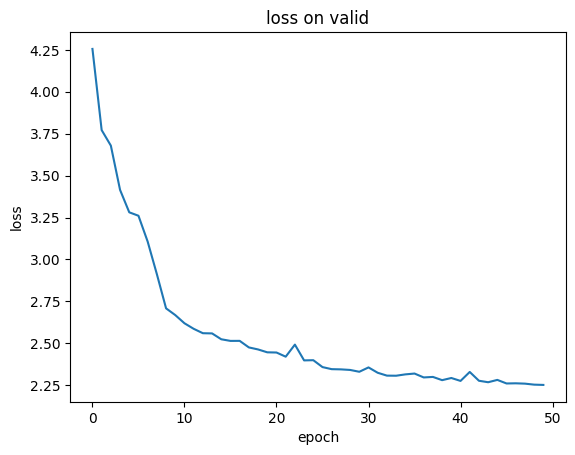

In [37]:
y = losses['val']
x = range(len(y))


plt.plot(x[:50], y[:50])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("loss on valid")
plt.show()

In [ ]:
# torch.save(model, "model_scaling.pth")

## Results

In [ ]:
model = torch.load('model_scaling.pth', weights_only=False)
model.to(device)

UpscaleCNN(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (7): ReLU()
    (8): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), p

Wybranie losowo 5 obrazów i porównanie z rozwiązaniem bazowym z biblioteki openCV

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11744143..1.188814].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05409469..0.99395514].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.100334466..0.99534434].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.057438787..1.1174362].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.013655335..1.1446753].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.039778892..1.1586962].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range

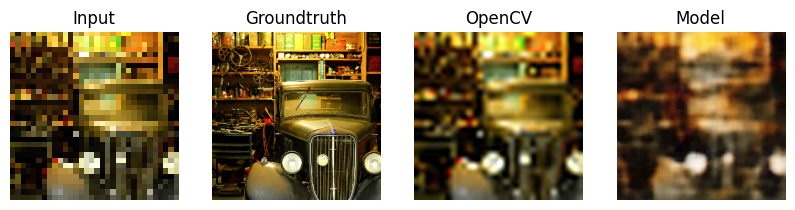

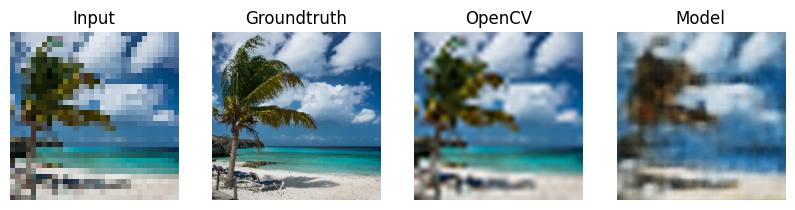

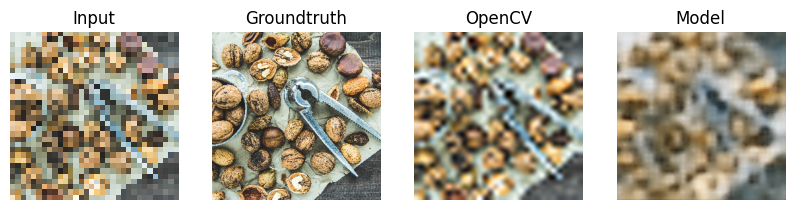

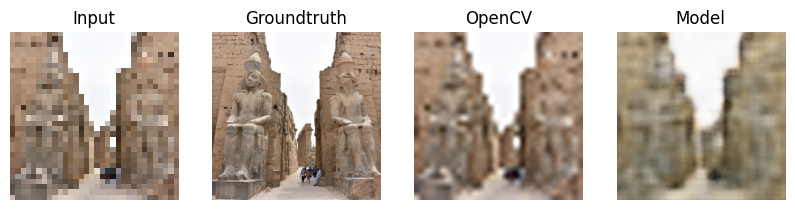

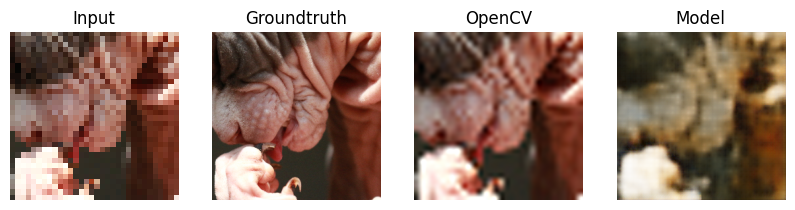

In [35]:
model.eval()

for i in range(5):
    a = random.choice(valid_dataset)

    input = a[0].permute(1, 2, 0).detach().numpy()

    out = model(a[0].to(device))
    out = out.permute(1, 2, 0).detach().cpu().numpy()

    dest = a[1].permute(1, 2, 0).detach().numpy()

    fig, axes = plt.subplots(1, 4, figsize=(10, 5)) 

    axes[0].imshow(fix_colors(input))
    axes[0].axis('off')
    axes[0].set_title("Input")

    axes[1].imshow(fix_colors(dest))
    axes[1].axis('off')
    axes[1].set_title("Groundtruth")

    axes[2].imshow(fix_colors(classic_upscale(input)))
    axes[2].axis('off')
    axes[2].set_title("OpenCV")

    axes[3].imshow(fix_colors(out))
    axes[3].axis('off')
    axes[3].set_title("Model")

### Metryki

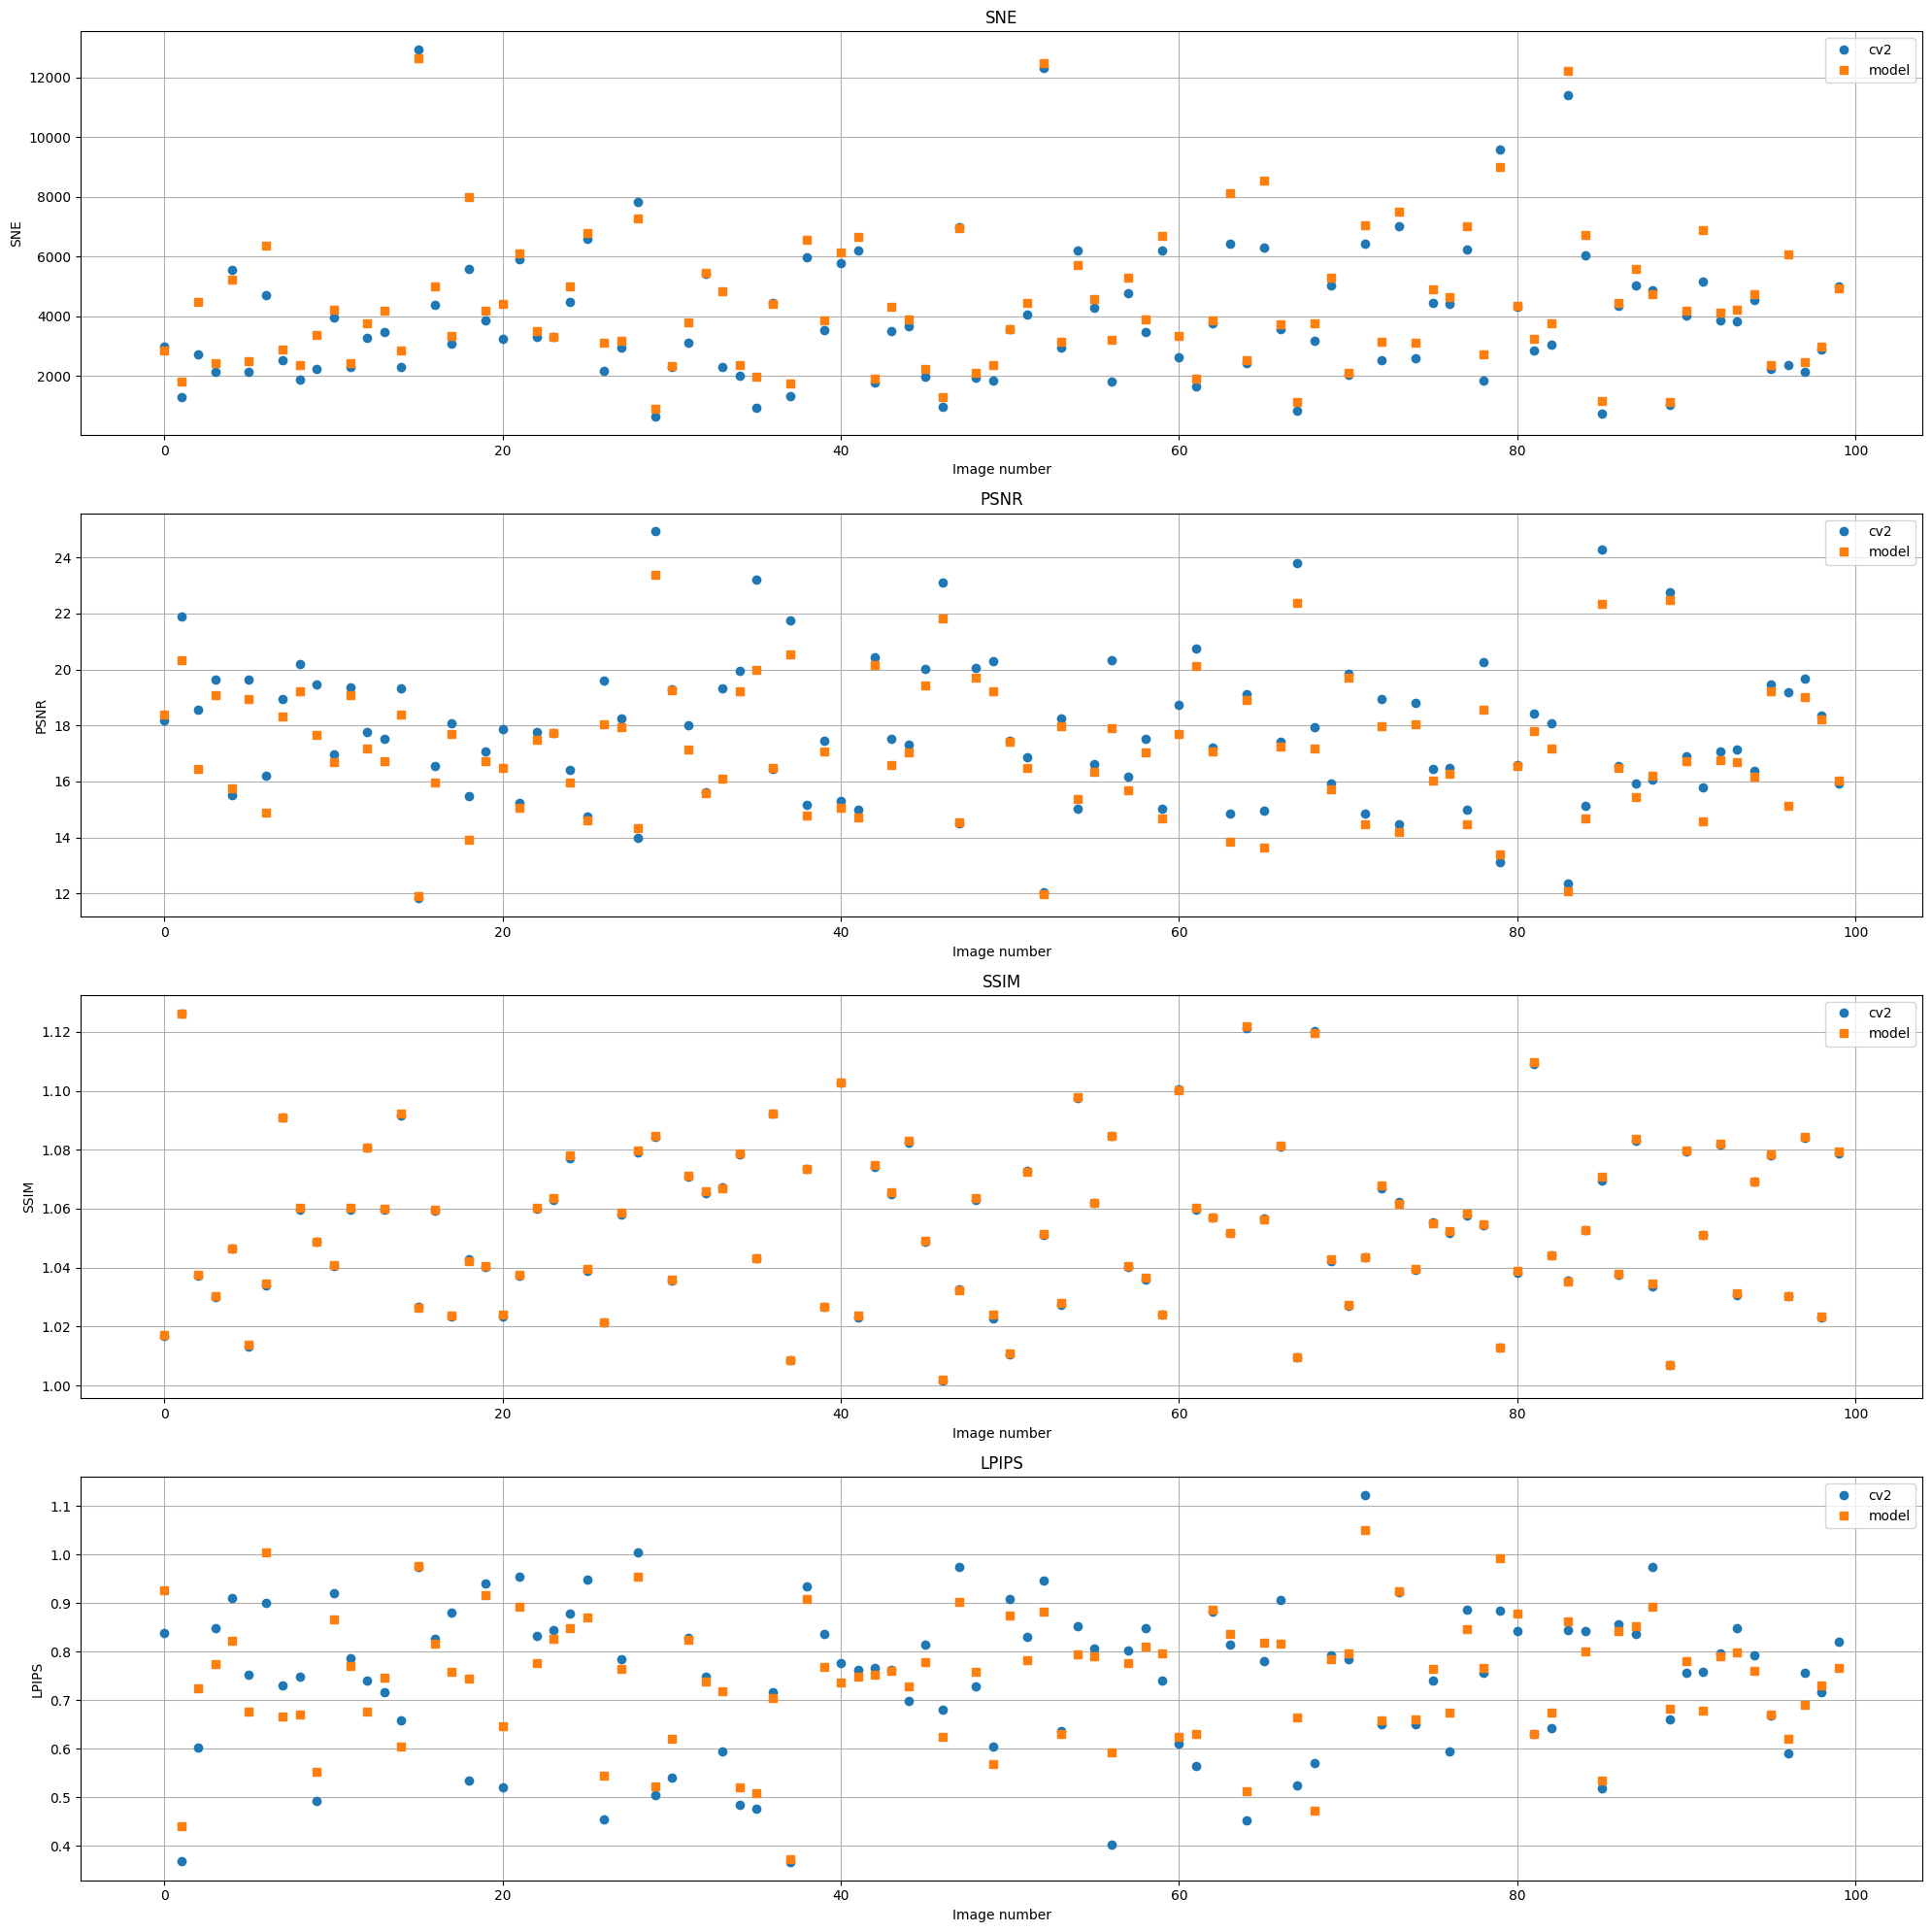

Metrics:
--------------------------------------------------
| Metric  | cv2        | Model      | Which Better
--------------------------------------------------
| SNE     |  3913.2354 |  4399.5249 | cv2
| PSNR    |    17.7095 |    17.0631 | cv2
| SSIM    |     1.0544 |     1.0547 | model
| LPIPS   |     0.7479 |     0.7465 | model
--------------------------------------------------


In [36]:
ground_truth_list = []
cv2_list = []
model_list = []

model.eval()

for x, y in valid_dataset:
    ground_truth_list.append(y.permute(1, 2, 0).detach().numpy())

    cv2_list.append(classic_upscale(x.permute(1, 2, 0).detach().numpy()))

    model_list.append(model(x.to(device)).permute(1, 2, 0).detach().cpu().numpy())


plot_metrics(ground_truth_list, cv2_list, model_list)

Otrzymane wyniki w metrykach są przybliżone do rozwiązań z cv2.